In [313]:
import os
import pandas as pd

project_path = os.getcwd()


train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')
test_data = pd.read_csv(project_path + '/data/kaggle_house_pred_test.csv')
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


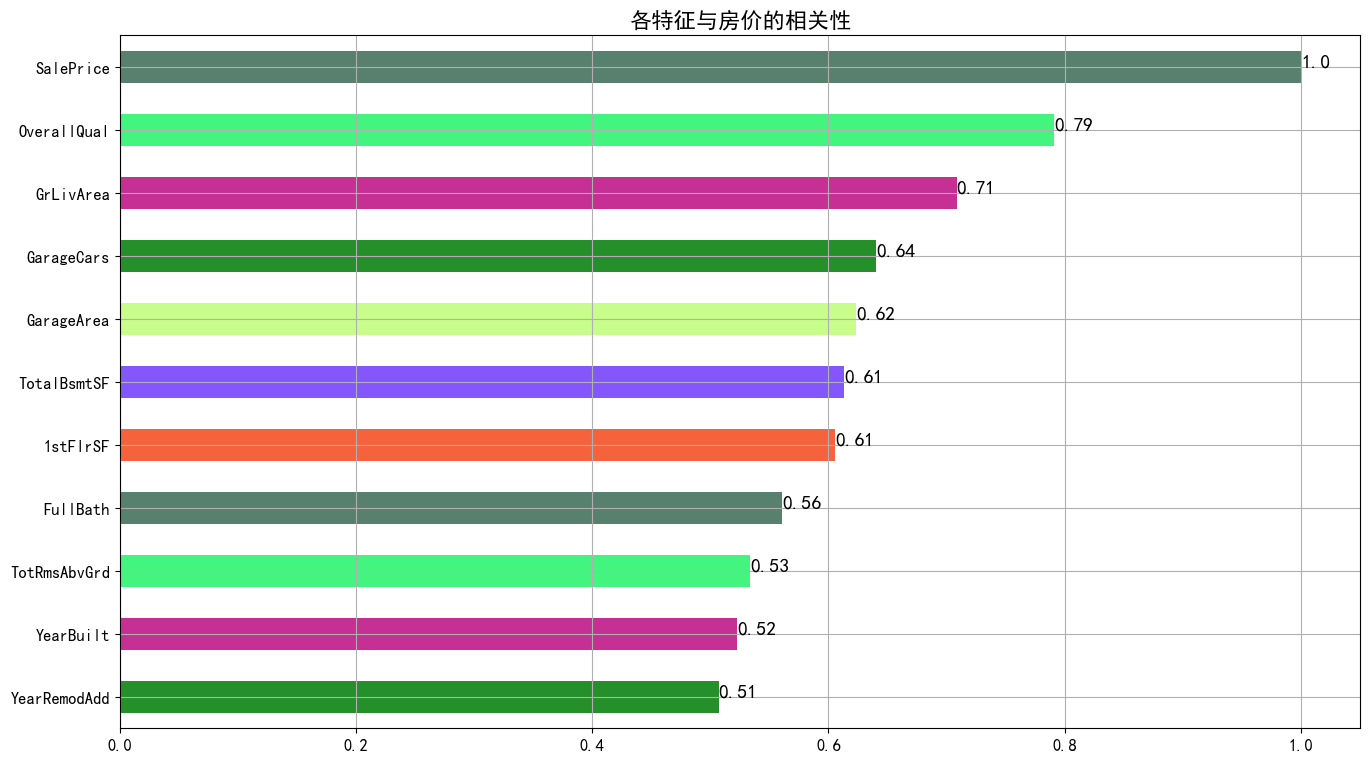

In [314]:
import matplotlib.pyplot as plt
import numpy as np


#自变量与的相关性
fig = plt.figure(figsize=(16,9))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 仅选择数值类型的特征
numeric_features = train_data.select_dtypes(include=[np.number])
corrs = abs(numeric_features.corr()['SalePrice']).sort_values(ascending=True)   #各特征与房价的相关性
f_corrs = corrs[corrs > 0.5]    #只保留相关性大于0.5的特征
f_corrs.plot.barh(color=np.random.rand(7,3))

for index, value in enumerate(f_corrs):# 在每个柱末端标注值
    plt.text(value, index, str(round(value, 2)), fontsize=14)
plt.rcParams["font.sans-serif"]=["SimHei"] #中文乱码(公式化处理)
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
plt.title('各特征与房价的相关性', fontsize=16)
plt.grid()
plt.show()

In [315]:
# 倒序
f1_corrs = f_corrs[::-1]
print(f1_corrs)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


C:\Users\Eason\AppData\Local\Temp\ipykernel_24936\3893397684.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i+1)


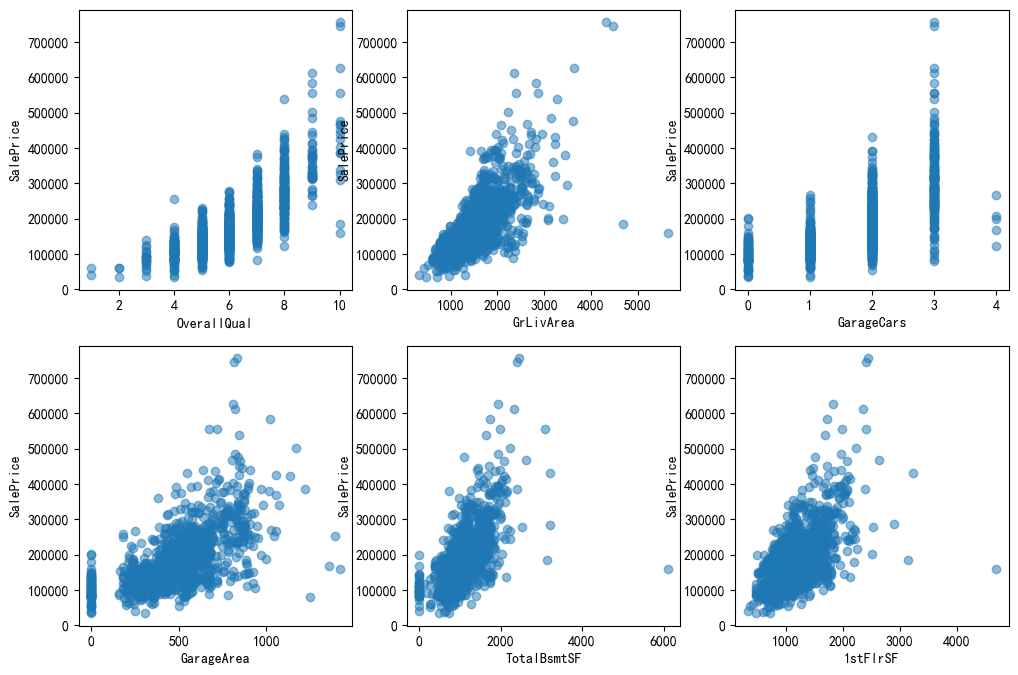

In [316]:
# 针对这些重要特征，我们可以绘制它们的散点图，以便直观地观察特征与房价之间的关系
fig = plt.figure(figsize=(12,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


for i, col in enumerate(f1_corrs.index[1:7]):
    plt.subplot(2, 3, i+1)
    plt.scatter(train_data[col], train_data['SalePrice'], alpha=0.5)# 数量用透明度表示
    plt.xlabel(col)
    plt.ylabel('SalePrice')

# 选择方法

## 1. Z-scores

In [317]:
from scipy import stats

# 获取数值类型的特征
features = train_data.select_dtypes(include=[np.number]).columns
print(len(features))
count = 0
for feature in features:
    # 计算特征值的Z-Score
    z_scores_feature = stats.zscore(train_data[feature])

    # 计算SalePrice的Z-Score
    z_scores_saleprice = stats.zscore(train_data['SalePrice'])

    # 获取特征值异常值的索引
    outliers_feature = np.where(np.abs(z_scores_feature) > 5)
    # 获取SalePrice异常值的索引
    outliers_saleprice = np.where(np.abs(z_scores_saleprice) > 5)

    # 合并两个异常值的索引
    outliers = np.union1d(outliers_feature, outliers_saleprice)

    # 检查这些索引是否在train_data的索引中
    outliers = [index for index in outliers if index in train_data.index]

    # 删除异常值
    train_data = train_data.drop(outliers)

    count+=len(outliers)
    
print(count)

38
133


## 2. 箱线图/四分位数范围法(Interquartile Range method，IQR method)

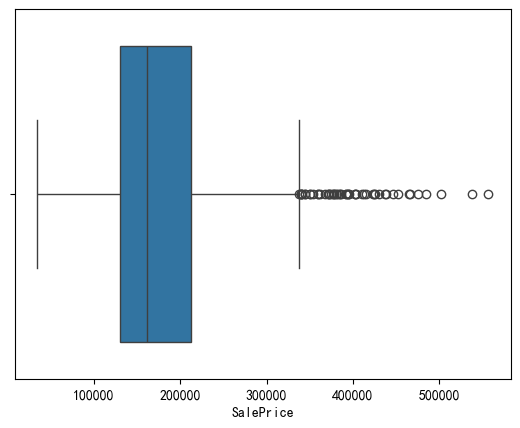

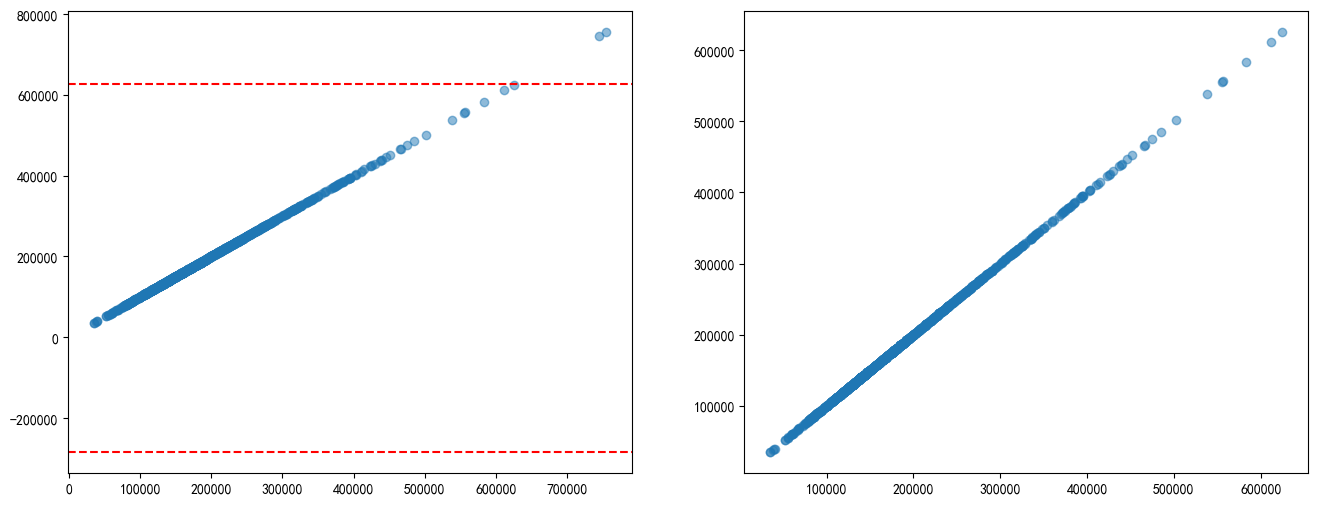

In [318]:
import seaborn as sns

# 绘制'SalePrice'的箱线图
sns.boxplot(x=train_data['SalePrice'])

# 计算'SalePrice'列的
Q1 = train_data['SalePrice'].quantile(0.25)
Q3 = train_data['SalePrice'].quantile(0.75)
# 计算IQR
IQR = Q3 - Q1
# 定义异常值的范围
lower_bound = Q1 - 5 * IQR
upper_bound = Q3 + 5 * IQR

train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.scatter(train_data['SalePrice'], train_data['SalePrice'], alpha=0.5)# 数量用透明度表示
plt.axhline(y=lower_bound, color='r', linestyle='--')
plt.axhline(y=upper_bound, color='r', linestyle='--')
# 删除异常值
train_data = train_data[(train_data['SalePrice'] >= lower_bound) & (train_data['SalePrice'] <= upper_bound)]

plt.subplot(1, 2, 2)
plt.scatter(train_data['SalePrice'], train_data['SalePrice'], alpha=0.5)# 数量用透明度表示

## 3. 马氏距离

In [319]:
from scipy.spatial import distance

train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')

# 选择数值类型的特征
train_data = train_data.select_dtypes(include=[np.number])
print('删除异常值前的数据集大小:', train_data.shape)
# 计算协方差矩阵和其逆矩阵
cov_matrix = np.cov(train_data.values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# 计算每个数据点的马氏距离
mahal_dist = []
for i in range(len(train_data)):
    mahal_dist.append(distance.mahalanobis(train_data.values[i], np.mean(train_data.values, axis=0), inv_cov_matrix))

# 转换为numpy数组
mahal_dist = np.array(mahal_dist)

# 定义阈值（例如，3倍的标准差）
threshold = np.mean(mahal_dist) + 3 * np.std(mahal_dist)

# 删除马氏距离大于阈值的数据点
train_data = train_data[mahal_dist <= threshold]

print('删除异常值后的数据集大小:', train_data.shape)    

删除异常值前的数据集大小: (1460, 38)
删除异常值后的数据集大小: (0, 38)


## 4. KMeans 聚类算法

基于平均值的聚类算法

In [340]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')
train_data = train_data.select_dtypes(include=[np.number])# 选择数值类型的特征

for feature in features:

    for i in range(len(train_data)):
        # 若为nan值，则补充为平均值
        if np.isnan(train_data[feature].values[i]):
            train_data[feature].values[i] = np.mean(train_data[feature])
            

    # 使用K均值聚类算法将数据点聚类
    kmeans = KMeans(n_clusters=3, random_state=0).fit(train_data[feature].values.reshape(-1, 1))


    # 使用每列的平均值填充NaN值
    train_data = train_data.apply(lambda x: x.fillna(x.mean()),axis=0)



    # 计算每个数据点到其所在簇的质心的距离
    distances = []
    for i in range(len(train_data)):
        distances.append(distance.euclidean(train_data.values[i], kmeans.cluster_centers_[kmeans.labels_[i]]))
    # 转换为numpy数组
    distances = np.array(distances)

    # 定义阈值（例如，3倍的标准差）
    threshold = np.mean(distances) + 3 * np.std(distances)

    # 删除距离大于阈值的数据点
    train_data = train_data[distances <= threshold]

c:\Users\Eason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Eason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Eason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Eason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

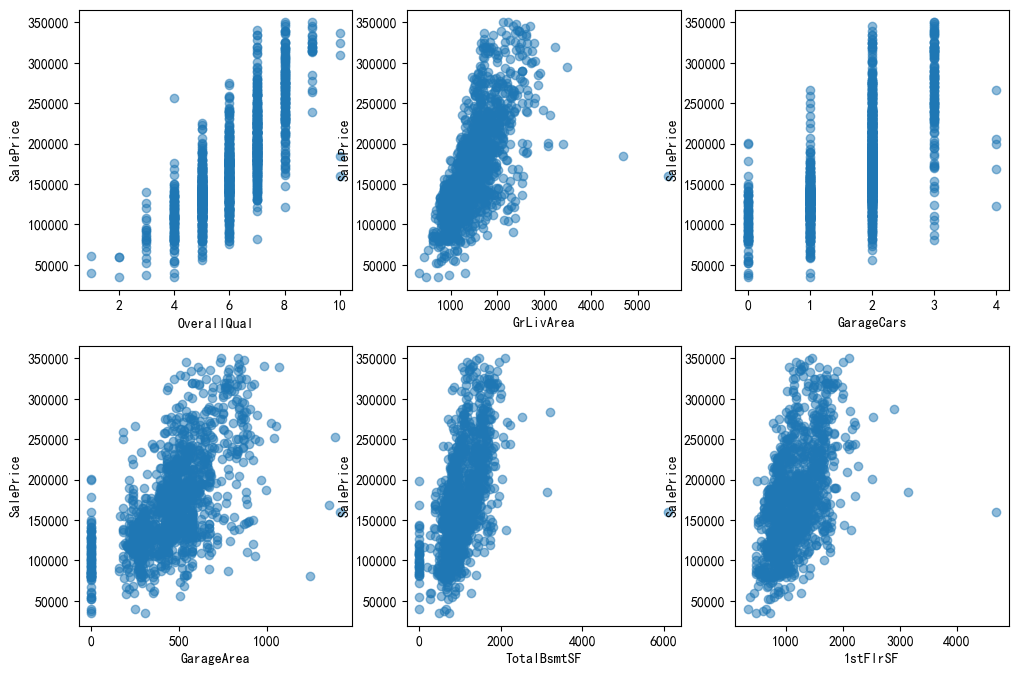

In [341]:
fix = plt.figure(figsize=(12,8))
for i, col in enumerate(f1_corrs.index[1:7]):
    plt.subplot(2, 3, i+1)
    plt.scatter(train_data[col], train_data['SalePrice'], alpha=0.5)# 数量用透明度表示
    plt.xlabel(col)
    plt.ylabel('SalePrice')

## 5. DBSCAN 聚类算法

基于密度的聚类算法

In [326]:
train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')

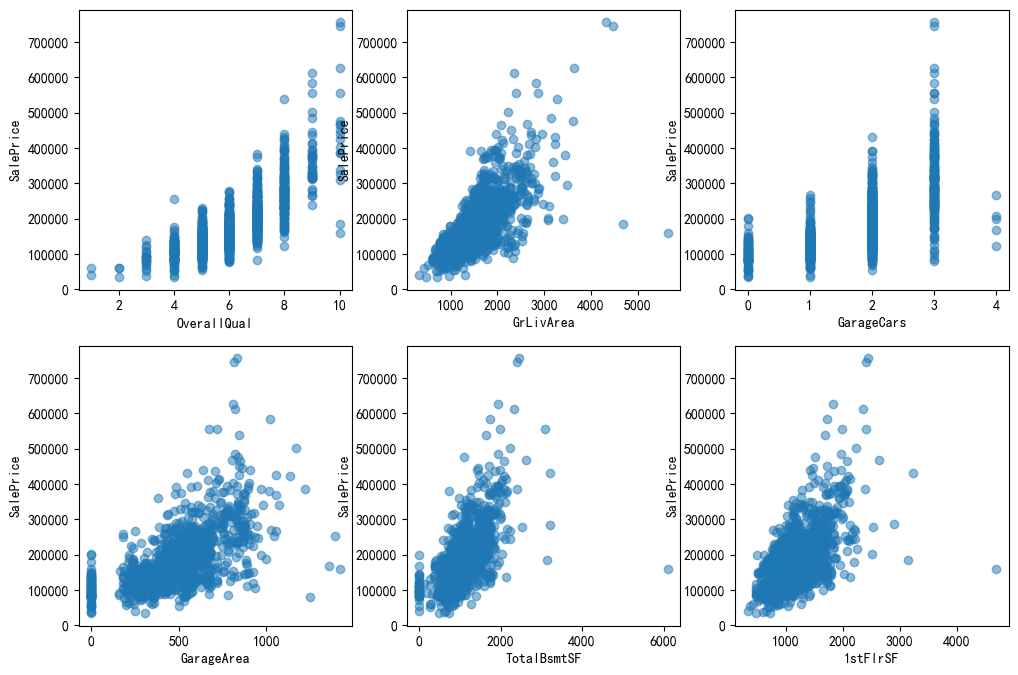

In [323]:
fix = plt.figure(figsize=(12,8))
for i, col in enumerate(f1_corrs.index[1:7]):
    plt.subplot(2, 3, i+1)
    plt.scatter(train_data[col], train_data['SalePrice'], alpha=0.5)# 数量用透明度表示
    plt.xlabel(col)
    plt.ylabel('SalePrice')

In [338]:
from sklearn.cluster import DBSCAN

# 加载数据
train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')

# 选择数值类型的特征
train_data = train_data.select_dtypes(include=[np.number])

# 使用每列的平均值填充NaN值
train_data = train_data.apply(lambda x: x.fillna(x.mean()),axis=0)

print('删除异常值前的数据集大小:', train_data.shape)
for feature in features:
    # 使用DBSCAN算法将数据点聚类
    dbscan = DBSCAN(eps=10, min_samples=3).fit(train_data[feature].values.reshape(-1, 1))

    # 标记异常值
    train_data[feature + '_anomaly'] = dbscan.labels_

    # 删除异常值
    train_data = train_data[train_data[feature + '_anomaly'] != -1]

    # 删除添加的异常值标记列
    train_data = train_data.drop([feature + '_anomaly'], axis=1)

print('删除异常值后的数据集大小:', train_data.shape)

删除异常值前的数据集大小: (1460, 38)
删除异常值后的数据集大小: (406, 38)


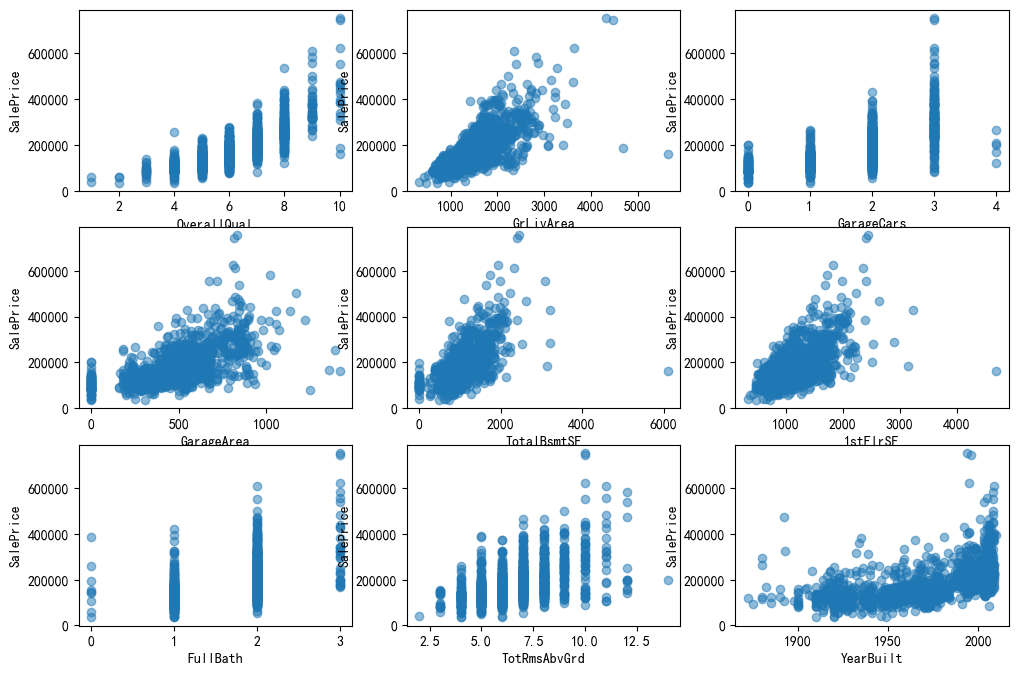

In [355]:

train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')
fix = plt.figure(figsize=(12,8))
for i, col in enumerate(f1_corrs.index[1:10]):
    plt.subplot(3, 3, i+1)
    plt.scatter(train_data[col], train_data['SalePrice'], alpha=0.5)# 数量用透明度表示
    plt.xlabel(col)
    plt.ylabel('SalePrice')

## 6. LOF

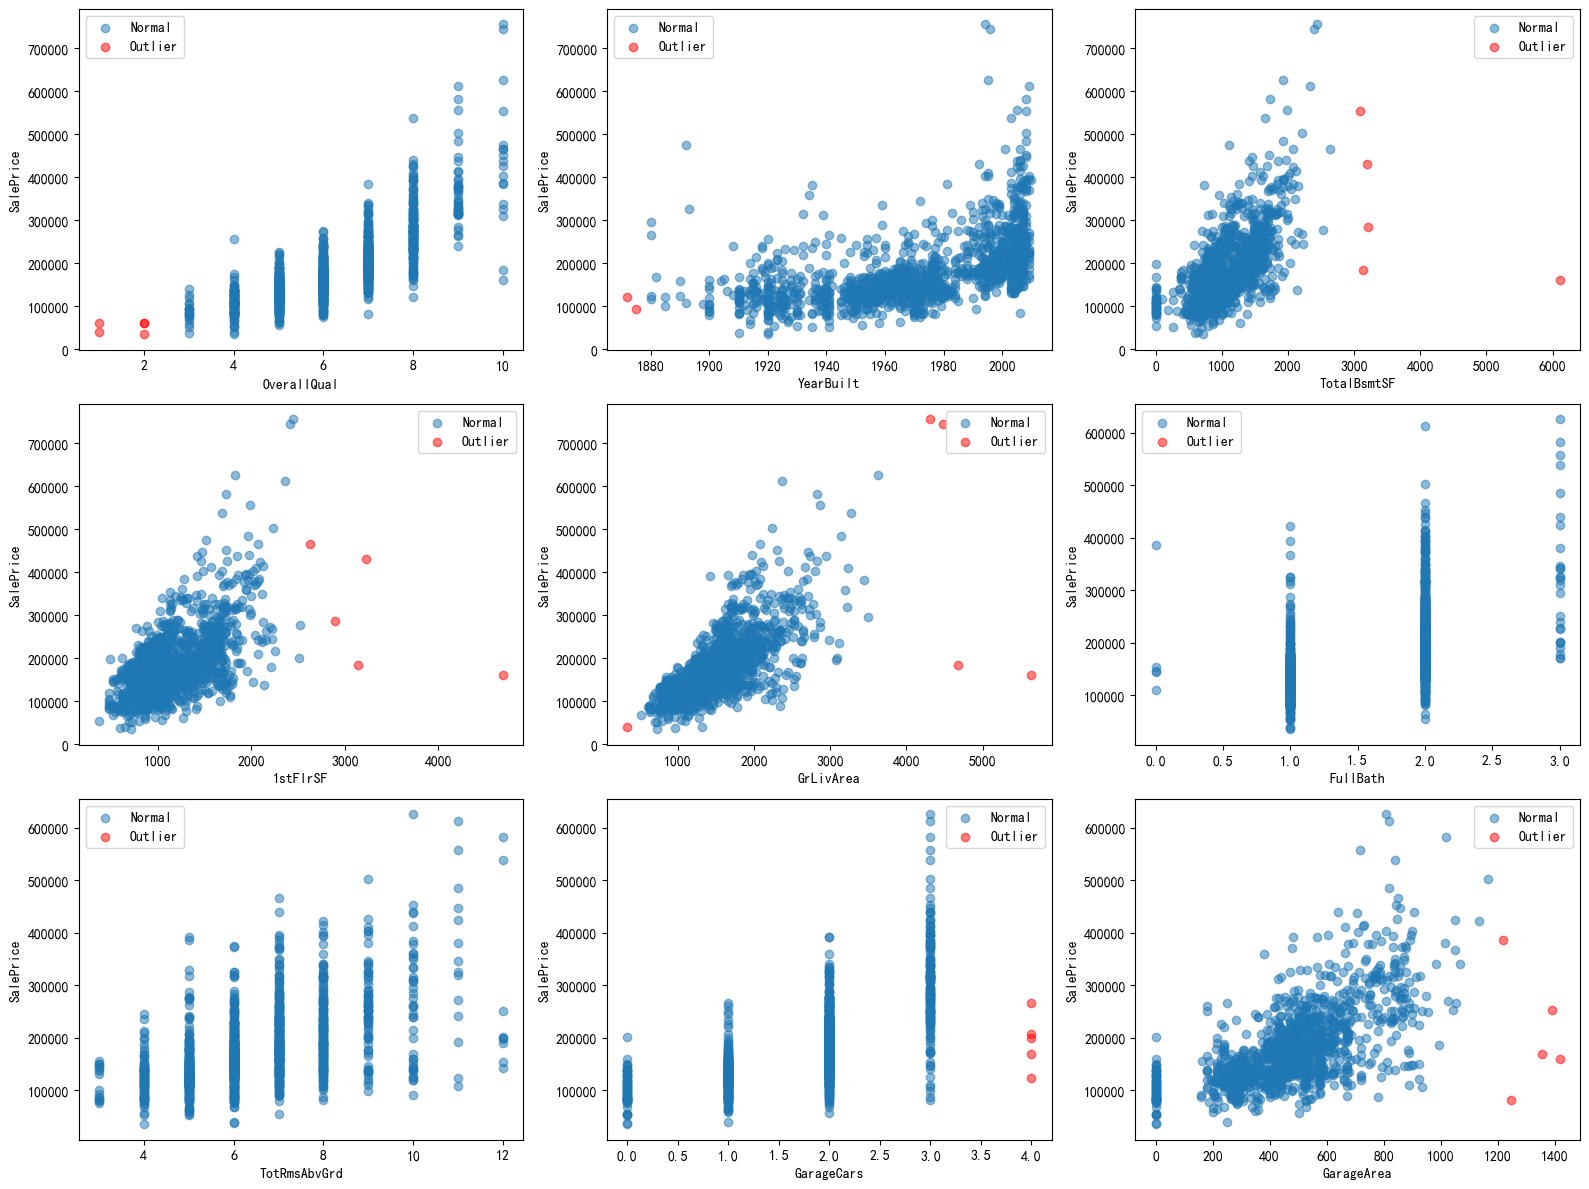

删除异常值后的数据集大小: (1358, 38)


In [374]:
from sklearn.neighbors import LocalOutlierFactor

# 加载数据
train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')
# 选择数值类型的特征
train_data = train_data.select_dtypes(include=[np.number])
# 使用每列的中位数填充NaN值
train_data = train_data.apply(lambda x: x.fillna(x.median()),axis=0)


count = 1
fig = plt.figure(figsize=(16, 12))

# 用于存储所有的异常值索引
outliers_indices = []

for feature in features:
    # 创建LOF检测器
    lof = LocalOutlierFactor(n_neighbors=100, contamination=0.0025)

    # 使用LOF检测器对数据进行拟合和预测
    y_pred = lof.fit_predict(train_data[feature].values.reshape(-1, 1))

    # 异常值被标记为-1，正常值被标记为1
    # 找出异常值
    outliers = train_data[y_pred == -1]
    outliers_indices.extend(outliers.index.tolist())

    if feature in ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']:
        # 绘制散点图，正常值用蓝色，异常值用红色
        plt.subplot(3, 3, count)
        plt.scatter(train_data.loc[train_data.index.difference(outliers_indices), feature], train_data.loc[train_data.index.difference(outliers_indices), 'SalePrice'], alpha=0.5, label='Normal')
        plt.scatter(outliers[feature], outliers['SalePrice'], alpha=0.5, color='red', label='Outlier')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.legend()
        count += 1

plt.tight_layout()
plt.show()

# 删除异常值
train_data = train_data.drop(outliers_indices)

print('删除异常值后的数据集大小:', train_data.shape)

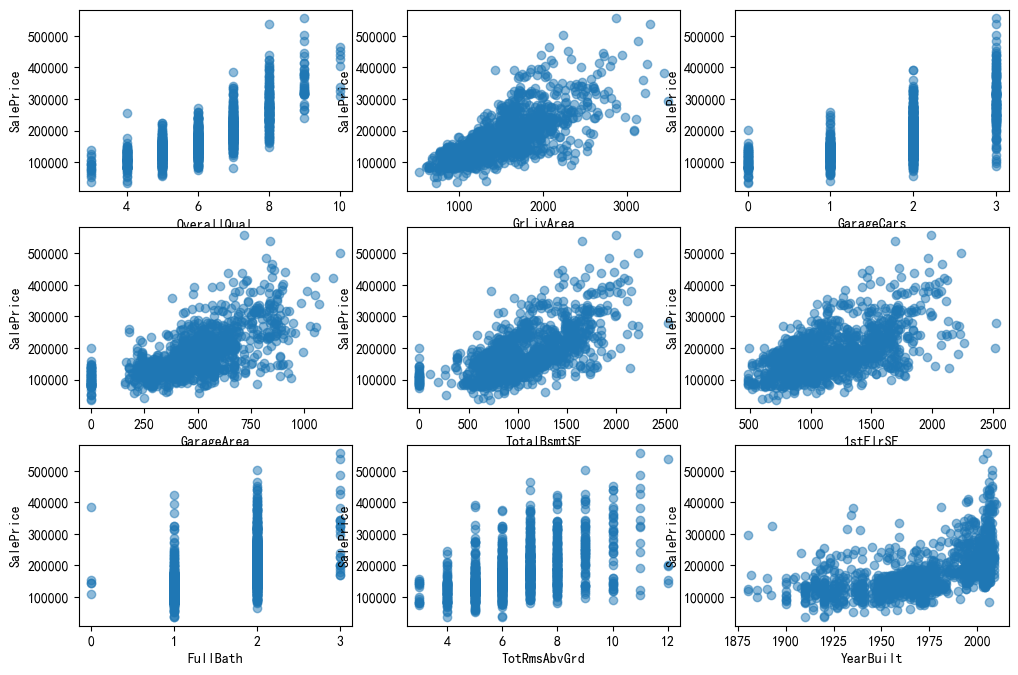

In [375]:
fix = plt.figure(figsize=(16,8))
for i, col in enumerate(f1_corrs.index[1:10]):
    plt.subplot(3, 3, i+1)
    plt.scatter(train_data[col], train_data['SalePrice'], alpha=0.5)# 数量用透明度表示
    plt.xlabel(col)
    plt.ylabel('SalePrice')

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

train_data = pd.read_csv(project_path + '/data/kaggle_house_pred_train.csv')
train_data = train_data.select_dtypes(include=[np.number])# 选择数值类型的特征

for feature in features:

    for i in range(len(train_data)):
        # 若为nan值，则补充为平均值
        if np.isnan(train_data[feature].values[i]):
            train_data[feature].values[i] = np.mean(train_data[feature])
            

    # 使用K均值聚类算法将数据点聚类
    kmeans = KMeans(n_clusters=3, random_state=0).fit(train_data[feature].values.reshape(-1, 1))


    # 使用每列的平均值填充NaN值
    train_data = train_data.apply(lambda x: x.fillna(x.mean()),axis=0)



    # 计算每个数据点到其所在簇的质心的距离
    distances = []
    for i in range(len(train_data)):
        distances.append(distance.euclidean(train_data.values[i], kmeans.cluster_centers_[kmeans.labels_[i]]))
    # 转换为numpy数组
    distances = np.array(distances)

    # 定义阈值（例如，3倍的标准差）
    threshold = np.mean(distances) + 3 * np.std(distances)

    # 删除距离大于阈值的数据点
    train_data = train_data[distances <= threshold]

c:\Users\Eason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Eason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Eason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Eason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus